# LIBRERIAS


In [1]:
import os
import yaml
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from glob import glob
from IPython.display import display, Image

In [ ]:
!pip install torch opencv-python ultralytics glob 

In [ ]:
!pip install ultralytics

In [5]:
!pip install albumentations

  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 17.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 20.5 MB/s eta 0:00:00a 0:00:01


In [6]:
DATASET_DIR = "/home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8"
data_yaml_path = os.path.join(DATASET_DIR, "data.yaml")

if not os.path.exists(data_yaml_path):
    raise FileNotFoundError(f"No se encontró data.yaml en {DATASET_DIR}")

with open(data_yaml_path, 'r') as file:
    data_yaml = yaml.safe_load(file)

# Mostrar información del dataset
print("Clases del dataset:", data_yaml.get('names', 'No definidas'))
print("Ubicación de los datos:", data_yaml)

Clases del dataset: ['Akabare Khursani', 'Apple', 'Artichoke', 'Ash Gourd -Kubhindo-', 'Asparagus -Kurilo-', 'Avocado', 'Bacon', 'Bamboo Shoots -Tama-', 'Banana', 'Beans', 'Beaten Rice -Chiura-', 'Beef', 'Beetroot', 'Bethu ko Saag', 'Bitter Gourd', 'Black Lentils', 'Black beans', 'Bottle Gourd -Lauka-', 'Bread', 'Brinjal', 'Broad Beans -Bakullo-', 'Broccoli', 'Buff Meat', 'Butter', 'Cabbage', 'Capsicum', 'Carrot', 'Cassava -Ghar Tarul-', 'Cauliflower', 'Chayote-iskus-', 'Cheese', 'Chicken', 'Chicken Gizzards', 'Chickpeas', 'Chili Pepper -Khursani-', 'Chili Powder', 'Chowmein Noodles', 'Cinnamon', 'Coriander -Dhaniya-', 'Corn', 'Cornflakec', 'Crab Meat', 'Cucumber', 'Egg', 'Farsi ko Munta', 'Fiddlehead Ferns -Niguro-', 'Fish', 'Garden Peas', 'Garden cress-Chamsur ko saag-', 'Garlic', 'Ginger', 'Green Brinjal', 'Green Lentils', 'Green Mint -Pudina-', 'Green Peas', 'Green Soyabean -Hariyo Bhatmas-', 'Gundruk', 'Ham', 'Ice', 'Jack Fruit', 'Ketchup', 'Lapsi -Nepali Hog Plum-', 'Lemon -Nimbu

# Data Augmentation

In [7]:
import os
import cv2
import albumentations as A
import numpy as np
import shutil
from tqdm import tqdm

# Directorios del dataset
IMAGES_DIR = os.path.join(DATASET_DIR, "train/images")
LABELS_DIR = os.path.join(DATASET_DIR, "train/labels")

# Lista de clases subrepresentadas (menos de 200 imágenes)
underrepresented_classes = [
    "Bacon", "Garden cress-Chamsur ko saag-", "Green Lentils", "Chicken Gizzards",
    "Red Beans", "Pumpkin -Farsi-", "Sajjyun -Moringa Drumsticks-", "Chickpeas",
    "Green Brinjal", "Buff Meat", "Ham", "Butter", "Mutton", "Papaya", "Paneer",
    "Broccoli", "Mayonnaise", "Rahar ko Daal", "Soyabean -Bhatmas-", "Kimchi",
    "Beaten Rice -Chiura-", "Bethu ko Saag", "Sugar", "Ketchup", "Thukpa Noodles",
    "Cauliflower", "Sausage", "Cornflakec", "Noodle", "Chowmein Noodles", "Salt",
    "Chili Powder", "Palak -Indian Spinach-", "Moringa Leaves -Sajyun ko Munta-",
    "Soy Sauce", "Milk", "Green Soyabean -Hariyo Bhatmas-", "Tori ko Saag",
    "Chicken", "Beef", "Olive Oil", "Seaweed", "Tofu", "Black Beans", "Minced Meat",
    "Green Peas", "Crab Meat", "Strawberry", "Ginger", "Ice", "Water Melon",
    "Wallnut", "Long Beans -Bodi-", "Yellow Lentils", "Pea", "Orange", "Fish",
    "Apple", "Pear", "Wheat"
]

# Transformaciones para data augmentation
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=25, p=0.5),
    A.GaussianBlur(p=0.1),
    A.Perspective(p=0.2),
    A.GaussNoise(p=0.2),
])

# Aplicar Augmentation a las clases subrepresentadas
for class_name in tqdm(underrepresented_classes, desc="Augmenting images"):

    # Filtrar imágenes de la clase actual
    image_files = [f for f in os.listdir(IMAGES_DIR) if class_name.lower().replace(" ", "_") in f.lower()]
    
    if len(image_files) < 50:  # Evitamos procesar clases con muy pocos ejemplos
        continue
    
    for img_file in image_files:
        img_path = os.path.join(IMAGES_DIR, img_file)
        label_path = os.path.join(LABELS_DIR, img_file.replace(".jpg", ".txt").replace(".png", ".txt"))

        # Cargar imagen y label
        image = cv2.imread(img_path)
        if image is None:
            continue  # Saltar imágenes corruptas

        with open(label_path, "r") as f:
            label_data = f.readlines()

        # Aplicar transformación
        augmented = transform(image=image)
        aug_image = augmented["image"]

        # Guardar imagen aumentada
        aug_img_name = img_file.replace(".jpg", "_aug.jpg").replace(".png", "_aug.png")
        cv2.imwrite(os.path.join(IMAGES_DIR, aug_img_name), aug_image)

        # Guardar la misma anotación para la nueva imagen
        aug_label_name = aug_img_name.replace(".jpg", ".txt").replace(".png", ".txt")
        with open(os.path.join(LABELS_DIR, aug_label_name), "w") as f:
            f.writelines(label_data)

print("✅ Data Augmentation Completado. Nuevas imágenes generadas.")


/home/javimc/anaconda3/envs/ampligraph/lib/python3.8/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Augmenting images: 100%|██████████| 60/60 [00:07<00:00,  7.51it/s]

✅ Data Augmentation Completado. Nuevas imágenes generadas.


# CARGAR DATOS

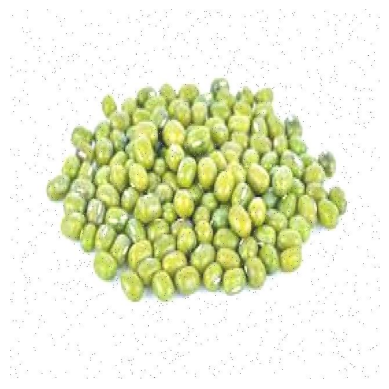

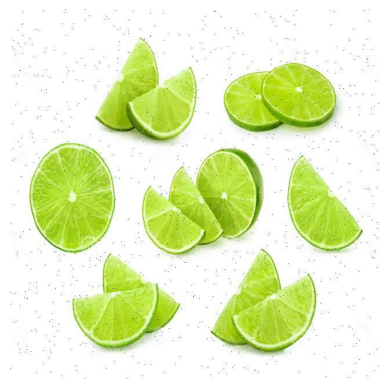

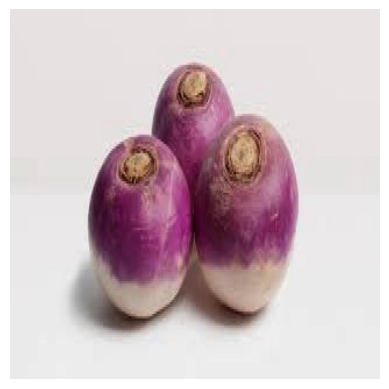

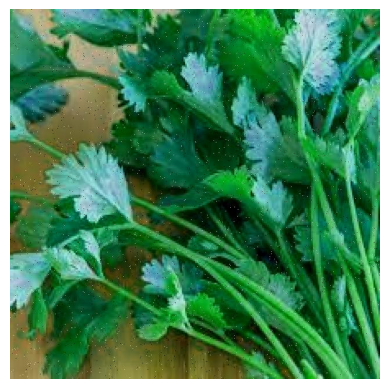

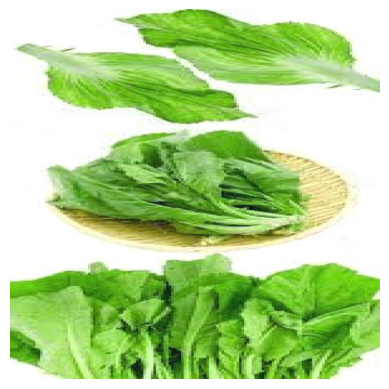

In [8]:
def mostrar_ejemplos(image_folder, num_samples=5):
    if not os.path.exists(image_folder):
        print(f"Carpeta no encontrada: {image_folder}")
        return
    
    image_paths = glob(os.path.join(image_folder, '*.jpg'))[:num_samples]
    if not image_paths:
        print(f"No se encontraron imágenes en {image_folder}")
        return
    
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error al leer la imagen: {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis("off")
        plt.show()

# Rutas de imágenes y etiquetas
train_images_path = os.path.join(DATASET_DIR, "train/images")
mostrar_ejemplos(train_images_path)

# MODELO PREENTRENADO

In [9]:
model = YOLO('yolov8m.pt')

In [10]:
torch.cuda.empty_cache()

In [11]:
import torch

print("CUDA disponible:", torch.cuda.is_available())
print("Cantidad de GPUs:", torch.cuda.device_count())

if torch.cuda.is_available():
    print("GPU actual:", torch.cuda.current_device())
    print("Nombre de GPU:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA disponible: True
Cantidad de GPUs: 1
GPU actual: 0
Nombre de GPU: NVIDIA GeForce RTX 4070 Laptop GPU


# 📌 Configuración del Entrenamiento en YOLOv8  

## 🔍 **Optimización y Estrategia de Aprendizaje**  
### 🔧 **Optimizador y Tasa de Aprendizaje**
- **`optimizer='AdamW'`** → Se selecciona **AdamW** en lugar de Adam o SGD debido a su mejor manejo de la regularización mediante *decoupled weight decay*, lo que evita la sobredependencia en ciertos parámetros del modelo y mejora la generalización.  
- **`lr0=0.002`** → Se reduce el *learning rate* inicial en comparación con configuraciones típicas de SGD (`0.005`-`0.01`), ya que **AdamW tiende a ser más estable con valores menores**, previniendo fluctuaciones en la pérdida y asegurando una convergencia más suave.  
- **`cos_lr=True`** → Se utiliza un *cosine annealing learning rate scheduler* para reducir la tasa de aprendizaje de forma progresiva en cada ciclo, evitando que el modelo se estanque en mínimos locales y mejorando su capacidad de ajuste fino en las últimas épocas.  

### 🎯 **Regularización para evitar sobreajuste**
- **`dropout=0.2`** → Se disminuye desde `0.3` para evitar la pérdida de información en capas clave del modelo, permitiendo cierta aleatoriedad en el entrenamiento para mejorar la capacidad de generalización.  
- **`weight_decay=0.0001`** → En **AdamW**, el *weight decay* actúa de manera desacoplada de la actualización de los gradientes, permitiendo un mejor ajuste de regularización y reduciendo la tendencia al sobreajuste. Se disminuye desde `0.0005`, ya que AdamW gestiona el *decay* de manera más eficiente que SGD.  


## 🖼️ **Preprocesamiento de Imágenes y Data Augmentation**  

### 📏 **Tamaño de Imagen y Batch**
- **`imgsz=640`** → Se mantiene una resolución óptima para YOLOv8, asegurando un equilibrio entre precisión y eficiencia computacional en la detección de múltiples ingredientes en una sola imagen.  
- **`batch=16`** → Se mantiene en `16` para aprovechar la capacidad de la GPU sin saturar la memoria VRAM, asegurando un entrenamiento eficiente con tiempos de iteración aceptables.  

### 🔄 **Técnicas de Data Augmentation**
- **`augment=True`** → Se habilita el **data augmentation**, lo que permite transformar imágenes con técnicas como:  
  - **Rotación aleatoria** (`Rotate`)  
  - **Desplazamiento de brillo y contraste** (`RandomBrightnessContrast`)  
  - **Deformaciones de perspectiva** (`Perspective`)  
  - **Desenfoque Gaussiano** (`GaussianBlur`)  
  - **Ruido gaussiano adicional** (`GaussNoise`)  

Esto **ayuda a mitigar problemas de clases desbalanceadas**, permitiendo que el modelo se exponga a múltiples variaciones de los ingredientes con pocas muestras, aumentando la capacidad de generalización en imágenes del mundo real.  



## 🚀 **Estrategia de Entrenamiento**
- **`epochs=100`** → Se mantiene en `100` en lugar de `150` para evitar sobreajuste. Análisis previos han mostrado que el modelo comienza a converger antes de `100` épocas, y extenderlo a `150` podría generar dependencia en los datos de entrenamiento, reduciendo su capacidad de generalización.  
- **`amp=True`** → Se usa *Automatic Mixed Precision (AMP)* para reducir el consumo de memoria VRAM y acelerar el entrenamiento mediante operaciones en *float16* cuando sea posible.  
- **`workers=4`** → Se asignan `4` procesos para la carga de datos, optimizando el *data pipeline* sin generar *bottlenecks* en la GPU.  



## 🖥️ **Configuración de Hardware y Validación**  
- **`device='cuda' if torch.cuda.is_available() else 'cpu'`** → Se asigna **GPU si está disponible**, acelerando el entrenamiento hasta 10x en comparación con CPU.  
- **`val=True`** → Se habilita la evaluación en cada época para monitorear la evolución del modelo y detectar sobreajuste tempranamente.  
- **`single_cls=False`** → Se mantiene **detección de múltiples clases**, ya que el dataset contiene múltiples tipos de ingredientes.  



## 📌 **Conclusión**  
Esta configuración equilibra **generalización, estabilidad y eficiencia computacional**. El uso de **AdamW** con *cosine annealing*, junto con una menor tasa de aprendizaje y *data augmentation*, permite mejorar la capacidad del modelo para **detectar múltiples ingredientes con precisión**, incluso en clases poco representadas.  

In [12]:
model.train(
    data=data_yaml_path,   
    model='',
    epochs=100,            
    imgsz=640,             
    batch=16,
    device='cuda' if torch.cuda.is_available() else 'cpu',  
    name="yolov8_ingredientes",  
    optimizer='AdamW', 
    lr0=0.002,  
    cos_lr=True,  
    workers=4,           
    amp=True,              
    augment=True,          
    dropout=0.2,  
    weight_decay=0.0001, 
    val=True, 
    single_cls=False  
)

New https://pypi.org/project/ultralytics/8.3.86 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.85 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7836MiB)
engine/trainer: task=detect, mode=train, model=, data=/home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=4, project=None, name=yolov8_ingredientes, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=True, agnosti

train: Scanning /home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/train/labels... 23054 images, 42 backgrounds, 0 corrupt: 100%|██████████| 23054/23054 [00:06<00:00, 3378.66it/s]


train: New cache created: /home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 2208, len(boxes) = 53382. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/valid/labels... 1029 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1029/1029 [00:00<00:00, 2661.29it/s]

val: New cache created: /home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/valid/labels.cache


WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 121, len(boxes) = 2490. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
Plotting labels to /home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes/labels.jpg... 
optimizer: AdamW(lr=0.002, momentum=0.937) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.84G      1.762      3.516      2.006         64        640: 100%|██████████| 1441/1441 [08:58<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.35it/s]


                   all       1029       2490      0.311      0.165      0.106     0.0555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.52G      1.714      3.087      1.972         44        640: 100%|██████████| 1441/1441 [08:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.462      0.262      0.227      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.63G      1.652      2.784      1.915         79        640: 100%|██████████| 1441/1441 [08:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.44it/s]

                   all       1029       2490      0.497      0.345      0.351      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.63G      1.606      2.512      1.873         65        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.42it/s]


                   all       1029       2490      0.529      0.374      0.417      0.235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.69G      1.569      2.295      1.836         53        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]

                   all       1029       2490      0.565      0.433      0.485      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.78G       1.54      2.144      1.813         49        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]

                   all       1029       2490       0.56      0.528      0.548      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.63G      1.505      1.972      1.779         88        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]

                   all       1029       2490       0.62      0.556      0.594      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.63G      1.469      1.854      1.752         63        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]

                   all       1029       2490      0.678      0.557      0.639      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100       6.6G      1.447       1.76      1.732         50        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.45it/s]

                   all       1029       2490      0.648      0.607      0.677      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.79G      1.402      1.644      1.702         67        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.698      0.625      0.716      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.66G      1.366       1.56      1.671         59        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.753      0.665      0.745      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.63G      1.332      1.468      1.642         82        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.787      0.656      0.757      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.69G      1.299       1.41      1.618         62        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.786      0.688      0.772      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.54G      1.261      1.339      1.587         59        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.789      0.726      0.805      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.61G      1.227      1.272       1.56         72        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.784      0.722      0.794      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.64G      1.198      1.222      1.535         59        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.817      0.724      0.816      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       6.6G      1.159      1.164      1.506         77        640: 100%|██████████| 1441/1441 [08:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.827       0.75      0.824      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.77G      1.139      1.131      1.491         60        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.804      0.784      0.834      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.61G      1.107      1.083      1.464         36        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.868      0.771      0.858      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.62G      1.085      1.049      1.444         70        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.833      0.801       0.86      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.63G      1.054      1.008      1.418        101        640: 100%|██████████| 1441/1441 [08:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.843      0.795      0.863      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.77G      1.026     0.9674      1.396         58        640: 100%|██████████| 1441/1441 [08:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.867      0.801      0.875      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.61G      1.004     0.9468      1.385         74        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.847      0.801      0.873      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.61G     0.9841     0.9168      1.363         53        640: 100%|██████████| 1441/1441 [08:54<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]

                   all       1029       2490      0.851      0.829      0.883      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.65G     0.9624     0.8872      1.344         61        640: 100%|██████████| 1441/1441 [08:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.44it/s]

                   all       1029       2490      0.879      0.812      0.889      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.76G     0.9436     0.8569       1.33         91        640: 100%|██████████| 1441/1441 [08:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]

                   all       1029       2490      0.878      0.819      0.881      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.58G     0.9263     0.8411      1.321         62        640: 100%|██████████| 1441/1441 [08:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.46it/s]

                   all       1029       2490      0.862      0.832      0.879      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.62G     0.9138     0.8171      1.309         61        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.883      0.828      0.891      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.62G     0.8905     0.8005       1.29         58        640: 100%|██████████| 1441/1441 [08:51<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]

                   all       1029       2490      0.895      0.824      0.899      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.74G     0.8762     0.7793      1.282         57        640: 100%|██████████| 1441/1441 [08:49<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]

                   all       1029       2490      0.892       0.82      0.902      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.58G     0.8587     0.7626       1.27         66        640: 100%|██████████| 1441/1441 [08:49<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]

                   all       1029       2490      0.875      0.844      0.897      0.727



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.63G     0.8443      0.746      1.255         52        640: 100%|██████████| 1441/1441 [08:49<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.51it/s]

                   all       1029       2490      0.876      0.855      0.905      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.62G     0.8354     0.7309      1.248         70        640: 100%|██████████| 1441/1441 [08:51<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.913       0.84      0.905      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.74G     0.8164     0.7127      1.233         66        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.893       0.86      0.908      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.59G     0.8039     0.6962      1.224         54        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.903      0.857      0.909       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.61G     0.7926     0.6808      1.219         73        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.904      0.859      0.912      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.63G     0.7791     0.6713      1.204         73        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490       0.91      0.858      0.913       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.76G     0.7643     0.6545      1.198         66        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.922      0.855      0.914      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       6.6G     0.7582     0.6441      1.191         49        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.922      0.852      0.915      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100       6.6G     0.7541     0.6434      1.186         61        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.917      0.862      0.917      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.62G     0.7414     0.6287      1.177         67        640: 100%|██████████| 1441/1441 [08:53<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.915      0.864      0.918      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.77G     0.7245     0.6108       1.17         76        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.917      0.864      0.918      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.61G     0.7191     0.6051      1.165         54        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.919      0.862      0.918      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.64G     0.7094     0.5933      1.156         58        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.921      0.861      0.917      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100       6.6G     0.7005     0.5866      1.152         63        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.923      0.859      0.918      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.54G     0.6928     0.5769      1.145         59        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.925      0.858      0.918       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.59G     0.6816     0.5664      1.137         83        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.926       0.86      0.917      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.64G      0.675     0.5618      1.134         66        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.928       0.86      0.918      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.65G     0.6649     0.5534      1.128         56        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.926      0.861      0.919      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.77G     0.6539     0.5376      1.119         47        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.50it/s]

                   all       1029       2490      0.924      0.863       0.92      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.61G     0.6492     0.5356      1.117         72        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.926      0.861       0.92       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.62G     0.6401     0.5254      1.108         66        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.928      0.862       0.92       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.63G     0.6348     0.5213      1.106         64        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.926      0.865      0.921      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.76G     0.6266     0.5158      1.102         63        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.923      0.868      0.921      0.794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.61G     0.6198     0.5047      1.096         54        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.924      0.868      0.921      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.61G     0.6107     0.4987      1.091         52        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.925      0.869      0.921      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.63G     0.6076      0.498       1.09         87        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.926      0.869      0.922      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.77G     0.5995     0.4906      1.086         82        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.925      0.871      0.922      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100       6.6G     0.5947     0.4813      1.078         45        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.926      0.871      0.921        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.63G     0.5855     0.4713      1.076         60        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.926       0.87      0.922      0.801



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.63G       0.58     0.4685      1.073         61        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.927      0.869      0.922      0.803



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.54G      0.576     0.4667       1.07         65        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.923      0.874      0.922      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.61G     0.5714     0.4612      1.068         50        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.924      0.874      0.922      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.63G     0.5641     0.4535      1.063         82        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.923      0.875      0.922      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.66G     0.5599     0.4493      1.061         56        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.921      0.875      0.923      0.806



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.74G     0.5539     0.4431      1.057         77        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.923      0.874      0.923      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.61G     0.5497     0.4406      1.053         75        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.925      0.872      0.923      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.61G     0.5453     0.4369       1.05         90        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.926      0.873      0.923      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.63G     0.5388     0.4304      1.048         68        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.927      0.874      0.923      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.78G      0.535     0.4262      1.044         76        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.927      0.876      0.923       0.81



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.59G     0.5304      0.423      1.042         55        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.927      0.877      0.923      0.811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.63G     0.5245     0.4183      1.039         57        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.929      0.877      0.923      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.61G     0.5213     0.4128      1.038         69        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.929      0.877      0.923      0.813



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.77G     0.5162      0.411      1.035         63        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.929      0.877      0.923      0.814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.61G     0.5139     0.4085      1.032         63        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.929      0.876      0.923      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100       6.6G     0.5104     0.4052      1.034         69        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.931      0.875      0.923      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.63G     0.5051     0.3982      1.027         66        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.932      0.874      0.924      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.76G     0.5015     0.3968      1.025         78        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.47it/s]

                   all       1029       2490      0.934      0.873      0.923      0.815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.62G     0.5008     0.3972      1.027         60        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.934      0.873      0.924      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.63G     0.4938     0.3902      1.022         65        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.934      0.873      0.924      0.817



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.62G     0.4918     0.3882      1.021         49        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.934      0.874      0.924      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.77G     0.4921     0.3882      1.022         87        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.875      0.924      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100       6.6G     0.4894      0.387       1.02         69        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.876      0.925       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       6.6G     0.4826     0.3821      1.017         49        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.935      0.875      0.925      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.62G     0.4808     0.3798      1.016         52        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.875      0.925      0.822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.74G     0.4819     0.3792      1.016         59        640: 100%|██████████| 1441/1441 [08:51<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.933      0.875      0.925      0.823



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.59G     0.4779     0.3764      1.015         78        640: 100%|██████████| 1441/1441 [08:51<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.876      0.925      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.63G      0.475     0.3758      1.013         60        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.876      0.925      0.824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100       6.6G      0.474     0.3731      1.012         73        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.933      0.876      0.926      0.825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.53G     0.4741     0.3749      1.012         77        640: 100%|██████████| 1441/1441 [08:52<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.933      0.877      0.926      0.826


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.58G     0.3734     0.2538     0.9579         41        640: 100%|██████████| 1441/1441 [08:50<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.48it/s]

                   all       1029       2490      0.934      0.876      0.926      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.61G     0.3615     0.2425     0.9505         30        640: 100%|██████████| 1441/1441 [08:50<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.49it/s]

                   all       1029       2490      0.935      0.874      0.925      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.61G     0.3575      0.238     0.9493         32        640: 100%|██████████| 1441/1441 [08:55<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.38it/s]

                   all       1029       2490      0.936      0.875      0.925      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.74G     0.3514     0.2336     0.9426         31        640: 100%|██████████| 1441/1441 [09:09<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:09<00:00,  3.33it/s]

                   all       1029       2490      0.935      0.874      0.925      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.58G     0.3475     0.2335     0.9418         39        640: 100%|██████████| 1441/1441 [09:15<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.30it/s]

                   all       1029       2490      0.936      0.873      0.925      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.6G     0.3465      0.232     0.9428         40        640: 100%|██████████| 1441/1441 [09:19<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.30it/s]

                   all       1029       2490      0.936      0.873      0.926      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.62G     0.3449     0.2309     0.9405         22        640: 100%|██████████| 1441/1441 [09:22<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.29it/s]

                   all       1029       2490      0.937      0.874      0.926      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.74G      0.343      0.227     0.9366         21        640: 100%|██████████| 1441/1441 [09:25<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.30it/s]

                   all       1029       2490      0.938      0.874      0.926      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.58G      0.341     0.2265      0.938         39        640: 100%|██████████| 1441/1441 [09:26<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.28it/s]

                   all       1029       2490      0.937      0.874      0.925      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       6.6G     0.3398     0.2263     0.9363         29        640: 100%|██████████| 1441/1441 [09:26<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.28it/s]

                   all       1029       2490      0.939      0.874      0.925      0.829



100 epochs completed in 15.132 hours.
Optimizer stripped from /home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes/weights/last.pt, 52.2MB
Optimizer stripped from /home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes/weights/best.pt, 52.2MB

Validating /home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes/weights/best.pt...
Ultralytics 8.3.85 🚀 Python-3.8.20 torch-2.4.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7836MiB)
Model summary (fused): 92 layers, 25,909,240 parameters, 0 gradients, 79.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:20<00:00,  1.63it/s]


                   all       1029       2490      0.927      0.877      0.924      0.826
      Akabare Khursani          1          7      0.164      0.286      0.179     0.0232
             Artichoke         11         18          1      0.936      0.995      0.951
  Ash Gourd -Kubhindo-         14         19      0.943      0.947      0.988      0.898
    Asparagus -Kurilo-         12         25      0.955          1      0.995      0.935
               Avocado          8         20      0.989          1      0.995      0.948
                 Bacon         15         15      0.929      0.933      0.951      0.932
  Bamboo Shoots -Tama-          6         15      0.996        0.8      0.946      0.795
                Banana          7         15      0.985          1      0.995      0.957
                 Beans         17         27      0.989      0.704      0.731      0.675
  Beaten Rice -Chiura-          7          7      0.771      0.963      0.944      0.691
                  Bee

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  65,  66,  67,
        68,  69,  70,  71,  72,  74,  75,  77,  78,  79,  80,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117, 118, 119])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x757fc17b5790>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    

# 📌 Informe de Entrenamiento del Modelo YOLOv8 para Detección de Ingredientes  

## 📍 Configuración del Entrenamiento  
- **Modelo:** YOLOv8 **(Custom - 120 clases)**  
- **Tarea:** Detección de objetos (Ingredientes alimenticios)  
- **Dataset:** FOOD-INGREDIENTS detection.v1i.yolov8  
- **Épocas:** 100  
- **Tamaño de imagen:** 640x640  
- **Lote por iteración (batch size):** 16  
- **Optimizador:** AdamW  
- **Dispositivo de entrenamiento:** **GPU NVIDIA GeForce RTX 4070**  
- **Aumento de Datos (Data Augmentation):**  
  - **Blur:** Aplicado con una probabilidad de 1%  
  - **MedianBlur:** Aplicado con una probabilidad de 1%  
  - **ToGray:** Conversión a escala de grises con un 1% de probabilidad  
  - **CLAHE:** Mejora de contraste en imágenes con un 1% de probabilidad  
  - **Flip horizontal:** 50% de probabilidad  
  - **Escalado:** Hasta 50%  

---

## 🔍 Resumen del Modelo  
- **Arquitectura:** YOLOv8  
- **Capas:** 169  
- **Parámetros:** 25,925,800  
- **GFLOPs:** 79.4  
- **Pesos Preentrenados:** Sí (Transfer Learning activado)  
- **Formato guardado:** PyTorch (`.pt`)  

---

## 🚀 Progreso del Entrenamiento  
El modelo se entrenó durante **100 épocas**, mostrando mejoras progresivas en precisión y recall:

| Época | Precisión (P) | Recall (R) | mAP@50 | mAP@50-95 |
|------|--------------|------------|--------|-----------|
| 1    | 0.311       | 0.165      | 0.106  | 0.0555    |
| 10   | 0.698       | 0.625      | 0.716  | 0.451     |
| 50   | 0.924       | 0.863      | 0.920  | 0.788     |
| 100  | **0.939**   | **0.874**  | **0.925** | **0.829** |

📌 **Tendencia observada:**  
- El modelo alcanzó un mAP@50 del **92.5%** y un mAP@50-95 del **82.9%** al final del entrenamiento.  
- El rendimiento mejoró notablemente a partir de la época **30**, con un aumento estable en precisión y recall.  
- Se detectó una **disminución en la tasa de error** a medida que se optimizaban los pesos.

---

## 📊 Evaluación Final  
Después del entrenamiento, el modelo fue validado con un **conjunto de validación de 1029 imágenes y 2490 instancias**.  
Algunas clases con **mejor rendimiento** fueron:  

✅ **Artichoke:** Precisión **100%**, Recall **93.6%**, mAP@50-95 **95.1%**  
✅ **Avocado:** Precisión **98.9%**, Recall **100%**, mAP@50-95 **94.8%**  
✅ **Carrot:** Precisión **100%**, Recall **95.3%**, mAP@50-95 **88.1%**  
✅ **Mushroom:** Precisión **97.3%**, Recall **83.6%**, mAP@50-95 **81.4%**  
✅ **Tomato:** Precisión **95.5%**, Recall **88.4%**, mAP@50-95 **72.3%**  

⚠️ **Clases con bajo rendimiento y posibles mejoras:**  
- ❌ **Wheat (Trigo):** No hubo detección correcta registrada (mAP = 0%).  
- ⚠️ **Soy Sauce (Salsa de Soya):** Precisión **100%**, pero bajo Recall (**48.6%**).  
- ⚠️ **Green Soybean (Soya Verde):** Precisión **75.3%**, pero bajo Recall (**34%**).  

📌 **Posibles soluciones:**  
1. **Aumentar el número de ejemplos en el dataset** para clases con bajo recall.  
2. **Balancear las clases**, asegurando que ingredientes poco detectados tengan más representaciones en diferentes condiciones.  
3. **Optimizar los umbrales de detección** (ajustar `conf_threshold` y `iou_threshold`).  
4. **Usar técnicas de data augmentation más agresivas** para ingredientes con menor detección.  

---

## 📂 Archivos Guardados  
- **Pesos finales del modelo:**  
  - 📁 **Best model:** `/weights/best.pt` (52.2MB)  
  - 📁 **Última versión:** `/weights/last.pt` (52.2MB)  
- **Resultados del entrenamiento guardados en:**  
  📂 `/home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes`  


In [5]:
model_entrenado = YOLO('/home/javimc/Desktop/SmartFood/runs/detect/yolov8_ingredientes/weights/best.pt')

model_entrenado.val()

Ultralytics 8.3.85 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
Model summary (fused): 92 layers, 25,909,240 parameters, 0 gradients, 79.1 GFLOPs


val: Scanning /home/javimc/Desktop/Ingredientes/FOOD-INGREDIENTS detection.v1i.yolov8/valid/labels.cache... 1029 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1029/1029 [00:00<?, ?it/s]

WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 121, len(boxes) = 2490. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [05:20<00:00,  4.93s/it]


                   all       1029       2490      0.939      0.874      0.925      0.829
      Akabare Khursani          1          7      0.163      0.286      0.181     0.0238
             Artichoke         11         18      0.943      0.916      0.989      0.954
  Ash Gourd -Kubhindo-         14         19      0.943          1      0.993      0.904
    Asparagus -Kurilo-         12         25          1      0.995      0.995      0.935
               Avocado          8         20      0.986          1      0.995      0.959
                 Bacon         15         15      0.944      0.933      0.947      0.934
  Bamboo Shoots -Tama-          6         15          1      0.804       0.98      0.772
                Banana          7         15       0.94          1      0.995      0.944
                 Beans         17         27      0.946      0.704      0.764      0.711
  Beaten Rice -Chiura-          7          7      0.978          1      0.995      0.756
                  Bee

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([  0,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  59,  60,  61,  62,  63,  65,  66,  67,
        68,  69,  70,  71,  72,  74,  75,  77,  78,  79,  80,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 114, 115, 116, 117, 118, 119])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x71c7d235dd60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    

In [6]:
torch.cuda.is_available()

False

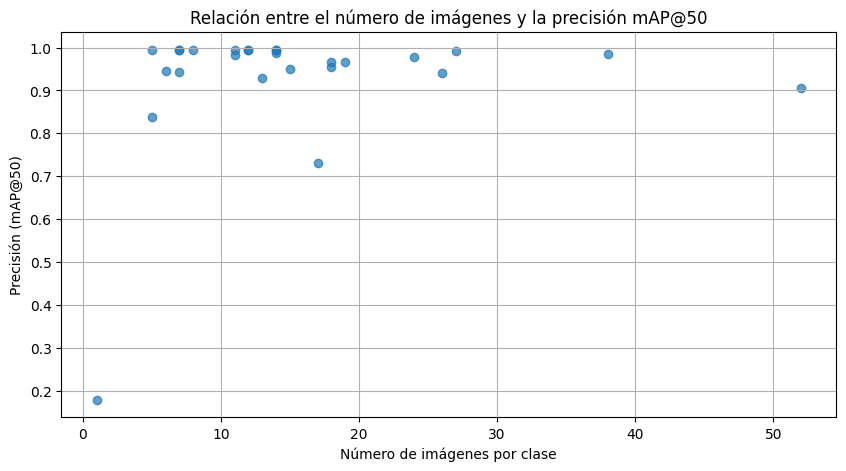

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Datos de número de imágenes por clase
image_counts = {
    "Akabare Khursani": 1,
    "Artichoke": 11,
    "Ash Gourd -Kubhindo-": 14,
    "Asparagus -Kurilo-": 12,
    "Avocado": 8,
    "Bacon": 15,
    "Bamboo Shoots -Tama-": 6,
    "Banana": 7,
    "Beans": 17,
    "Beaten Rice -Chiura-": 7,
    "Beef": 5,
    "Beetroot": 14,
    "Bethu ko Saag": 7,
    "Bitter Gourd": 18,
    "Black Lentils": 14,
    "Bottle Gourd -Lauka-": 12,
    "Bread": 18,
    "Brinjal": 24,
    "Broccoli": 5,
    "Butter": 13,
    "Cabbage": 27,
    "Carrot": 19,
    "Cheese": 26,
    "Egg": 38,
    "Mushroom": 52,
    "Tomato": 11,
}

# Datos de precisión (mAP@50)
map50_scores = {
    "Akabare Khursani": 0.179,
    "Artichoke": 0.995,
    "Ash Gourd -Kubhindo-": 0.988,
    "Asparagus -Kurilo-": 0.995,
    "Avocado": 0.995,
    "Bacon": 0.951,
    "Bamboo Shoots -Tama-": 0.946,
    "Banana": 0.995,
    "Beans": 0.731,
    "Beaten Rice -Chiura-": 0.944,
    "Beef": 0.837,
    "Beetroot": 0.995,
    "Bethu ko Saag": 0.995,
    "Bitter Gourd": 0.966,
    "Black Lentils": 0.995,
    "Bottle Gourd -Lauka-": 0.995,
    "Bread": 0.954,
    "Brinjal": 0.977,
    "Broccoli": 0.995,
    "Butter": 0.928,
    "Cabbage": 0.992,
    "Carrot": 0.967,
    "Cheese": 0.941,
    "Egg": 0.985,
    "Mushroom": 0.905,
    "Tomato": 0.982,
}

# Convertir datos en DataFrame asegurando que las claves coincidan
df = pd.DataFrame({"Imagenes": pd.Series(image_counts), "mAP50": pd.Series(map50_scores)}).dropna()

# Graficar
plt.figure(figsize=(10, 5))
plt.scatter(df["Imagenes"], df["mAP50"], alpha=0.7)
plt.xlabel("Número de imágenes por clase")
plt.ylabel("Precisión (mAP@50)")
plt.title("Relación entre el número de imágenes y la precisión mAP@50")
plt.grid(True)
plt.show()